# Part 2: Modeling Content-based Filtering with LogReg and Tfidf
---

- Importing the relevant libraries first...

In [1]:
#import requests
import random
#import time
import numpy as np
import pandas as pd
#from bs4 import BeautifulSoup as bs
import re
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction import stop_words
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.stem import WordNetLemmatizer
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score
from sklearn.metrics import multilabel_confusion_matrix
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
import joblib

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

/Users/jasonchia/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.feature_extraction.stop_words module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.feature_extraction.text. Anything that cannot be imported from sklearn.feature_extraction.text is now part of the private API.
  warnings.warn(message, FutureWarning)


## Importing X_legit and y which contain the shops that userid 2043 rated and ratings respectively
---

In [2]:
X_legit = pd.read_csv('yelp_data/xlegit.csv')
X_legit.shape

(980, 19307)

In [3]:
y = pd.read_csv('yelp_data/y.csv', squeeze=True)
y.head()

0    4.0
1    4.0
2    5.0
3    5.0
4    4.0
Name: user_rating, dtype: float64

In [4]:
#split the dataset into train and test sets first
X_train, X_test, y_train, y_test = train_test_split(X_legit, y, test_size=0.2, random_state=42, stratify=y)

In [5]:
y_train.value_counts(normalize=True)

4.0    0.479592
5.0    0.383929
3.0    0.118622
2.0    0.012755
1.0    0.005102
Name: user_rating, dtype: float64

<ul>
    
- The baseline accuracy will be 0.48 since that is the highest proportion among the training dataset's target classes

In [6]:
#instantiate scaler since not all of the features are of the same scale, eg. review_count and avg_store_rating
ss = StandardScaler()

In [7]:
#fitting the train and transforming both the train and test sets
X_train_sc = ss.fit_transform(X_train)
X_test_sc = ss.transform(X_test)

### Starting with most basic model - Logistic regression
---
<ul>

- Logistic Regression takes into account regularization (can tune between L1 and L2 norm) and is interpretable and it is commonly used for classification tasks (binary and multi-class) and thus should be the simplest and good model to begin with in predicting ratings (5 discrete classes - rating 1-5).

In [8]:
#getting a quick gauge of logreg's performance
#cross_val_score(LogisticRegression(max_iter=5000),X_train_sc,y_train,cv=10).mean()

<ul>
    
- ```cross_val_score``` was only 0.53...

In [9]:
#this is for tuning logreg
#params = {
#    'penalty':['l1','l2'],
#    'solver':['liblinear'],
#    'class_weight':['balanced'],
#    'C': np.logspace(-5, 0, 100)} 


#lr_gridsearch = GridSearchCV(LogisticRegression(), params, cv = 10, verbose = 1, n_jobs = -1)
#lr_gridsearch.fit(X_train_sc, y_train)

In [10]:
#loading a tuned logreg model from before (cell above)
loaded_model = joblib.load('yelp_data/lr_gs_model.sav')

In [11]:
#tuned logreg model apparently performed better
loaded_model.best_estimator_.score(X_test_sc,y_test)

0.8112244897959183

- Accuracy is pretty ok at 0.81 but need to check micro-averaged precision and recall and ROC AUC due to imbalanced classes. SMOTE and ADASYN have been experimented on before but they do not necessarily resample such that there is at least a 1 in each row under the "shops_..." series of columns and this makes rating predictions  for all shops for each user difficult. The highest score obtained was with ADASYN with an accuracy of 0.83 which is only 0.02 higher than a regular logreg model with class_weight tuned to be 'balanced'. As such, there is little benefit with over-sampling and thus shall stick with the original dataset.

In [12]:
#tuned logreg model's params
loaded_model.best_params_

{'C': 0.01519911082952933,
 'class_weight': 'balanced',
 'penalty': 'l1',
 'solver': 'liblinear'}

## Formulating recommendations for userid 2043 based on LogReg model
---

In [13]:
#stacking X_test as first step in regenerating the shops column for predictions
trial = X_test.stack()

In [14]:
#creating loop to re-generate original X_test order of shops
index_lst = []
outlets_lst = []
for n in range(len(trial.index)):
    if trial.index[n][1].startswith('shops_') and trial[n]!=0:
        index_lst.append(str(trial.index[n][0]))
        outlets_lst.append(trial.index[n][1])
index_lst = [int(x) for x in index_lst]
reconstructed_X_test = pd.DataFrame({'shops':outlets_lst}, index=index_lst)

In [15]:
#checking out the reconstructed df
reconstructed_X_test.head()

,shops
292,shops_got-luck-cafe-singapore
748,shops_symmetry-singapore
780,shops_the-bread-project-singapore
213,shops_dean-and-deluca-singapore-4
689,shops_stack-singapore


In [16]:
#creating column of rating predictions
rating_predictions = loaded_model.best_estimator_.predict(X_test_sc)

In [17]:
#adding column of rating predictions into reconstructed df
reconstructed_X_test['predicted_ratings']=rating_predictions

In [18]:
#checking the reconstructed df out after including the rating predictions' column...
reconstructed_X_test.head()

,shops,predicted_ratings
292,shops_got-luck-cafe-singapore,4.0
748,shops_symmetry-singapore,4.0
780,shops_the-bread-project-singapore,4.0
213,shops_dean-and-deluca-singapore-4,4.0
689,shops_stack-singapore,3.0


In [19]:
#adding the actual ratings into the reconstructed df for comparison later on...
reconstructed_X_test['actual_ratings']=y_test

In [20]:
#top 5 recommendations for userid 2043 based on content-based filtering (using logistic regression with tfidf) predictions
reconstructed_X_test.sort_values('predicted_ratings', ascending=False).head(5)

,shops,predicted_ratings,actual_ratings
477,shops_meidi-ya-singapore-2,5.0,5.0
630,shops_rayz-bistro-singapore,5.0,5.0
482,shops_meomi-cat-cafe-singapore,5.0,5.0
599,shops_ping-kee-popiah-singapore,5.0,5.0
483,shops_merchants-singapore,5.0,5.0


## Defining functions for evaluation of model
---

In [21]:
#defining function for obtaining tn, fp, fn, tp for each rating class for feeding into micro-avg precision and recall functions defined below
def cm_spec(y_true,y_pred,rating,state):
    if state=='tn':
        return multilabel_confusion_matrix(y_true,y_pred)[rating-1][0][0]
    elif state=='fp':
        return multilabel_confusion_matrix(y_true,y_pred)[rating-1][0][1]
    elif state=='fn':
        return multilabel_confusion_matrix(y_true,y_pred)[rating-1][1][0]
    else:
        return multilabel_confusion_matrix(y_true,y_pred)[rating-1][1][1]
    

In [22]:
#defining function for obtaining micro-avg precision
def micro_avg_precision(y_true,y_pred):
    return ((cm_spec(y_true,y_pred,1,'tp')+
                                                 cm_spec(y_true,y_pred,2,'tp')+
                                                 cm_spec(y_true,y_pred,3,'tp')+
                                                 cm_spec(y_true,y_pred,4,'tp')+
                                                 cm_spec(y_true,y_pred,5,'tp'))/(
                                                cm_spec(y_true,y_pred,1,'tp')+
                                                 cm_spec(y_true,y_pred,2,'tp')+
                                                 cm_spec(y_true,y_pred,3,'tp')+
                                                 cm_spec(y_true,y_pred,4,'tp')+
                                                 cm_spec(y_true,y_pred,5,'tp')+
                                                cm_spec(y_true,y_pred,1,'fp')+
                                                 cm_spec(y_true,y_pred,2,'fp')+
                                                 cm_spec(y_true,y_pred,3,'fp')+
                                                 cm_spec(y_true,y_pred,4,'fp')+
                                                 cm_spec(y_true,y_pred,5,'fp')))

In [23]:
#defining function for obtaining micro-avg recall
def micro_avg_recall(y_true,y_pred):
    return ((cm_spec(y_true,y_pred,1,'tp')+
                                                 cm_spec(y_true,y_pred,2,'tp')+
                                                 cm_spec(y_true,y_pred,3,'tp')+
                                                 cm_spec(y_true,y_pred,4,'tp')+
                                                 cm_spec(y_true,y_pred,5,'tp'))/(
                                                cm_spec(y_true,y_pred,1,'tp')+
                                                 cm_spec(y_true,y_pred,2,'tp')+
                                                 cm_spec(y_true,y_pred,3,'tp')+
                                                 cm_spec(y_true,y_pred,4,'tp')+
                                                 cm_spec(y_true,y_pred,5,'tp')+
                                                cm_spec(y_true,y_pred,1,'fn')+
                                                 cm_spec(y_true,y_pred,2,'fn')+
                                                 cm_spec(y_true,y_pred,3,'fn')+
                                                 cm_spec(y_true,y_pred,4,'fn')+
                                                 cm_spec(y_true,y_pred,5,'fn')))

In [24]:
#defining function for obtaining micro_avg_f1
def micro_avg_f1(y_true,y_pred):
    return 2 * ((micro_avg_precision(y_true,y_pred) * micro_avg_recall(y_true,y_pred))/(micro_avg_precision(y_true,y_pred) + micro_avg_recall(y_true,y_pred)))

In [25]:
#function to print out confusion matrix breakdown for each rating class
def confusion_breakdown(y_true,y_pred,rating):
    print("True negatives for rating {}: {}".format(
        rating,multilabel_confusion_matrix(y_true,y_pred)[rating-1][0][0]))
    print("False positives for rating {}: {}".format(
        rating,multilabel_confusion_matrix(y_true,y_pred)[rating-1][0][1]))
    print("False negatives for rating {}: {}".format(
        rating,multilabel_confusion_matrix(y_true,y_pred)[rating-1][1][0]))
    print("True positives for rating {}: {}".format(
        rating,multilabel_confusion_matrix(y_true,y_pred)[rating-1][1][1]))
    return "******************************************"

In [26]:
print(confusion_breakdown(y_test,rating_predictions,1))
print(confusion_breakdown(y_test,rating_predictions,2))
print(confusion_breakdown(y_test,rating_predictions,3))
print(confusion_breakdown(y_test,rating_predictions,4))
print(confusion_breakdown(y_test,rating_predictions,5))

True negatives for rating 1: 195
False positives for rating 1: 0
False negatives for rating 1: 1
True positives for rating 1: 0
******************************************
True negatives for rating 2: 193
False positives for rating 2: 0
False negatives for rating 2: 3
True positives for rating 2: 0
******************************************
True negatives for rating 3: 162
False positives for rating 3: 11
False negatives for rating 3: 0
True positives for rating 3: 23
******************************************
True negatives for rating 4: 76
False positives for rating 4: 26
False negatives for rating 4: 6
True positives for rating 4: 88
******************************************
True negatives for rating 5: 121
False positives for rating 5: 0
False negatives for rating 5: 27
True positives for rating 5: 48
******************************************


In [27]:
#can tell that this model performed poorly in predicting ratings 1 and 2 since it is unable to pick up any true positives for these 2 rating classes...
y_test.value_counts()

4.0    94
5.0    75
3.0    23
2.0     3
1.0     1
Name: user_rating, dtype: int64

In [28]:
print("Gridsearched LogReg with balanced class_weight yielded micro_avg_precision of ", micro_avg_precision(y_test,rating_predictions))

Gridsearched LogReg with balanced class_weight yielded micro_avg_precision of  0.8112244897959183


In [29]:
print("Gridsearched LogReg with balanced class_weight yielded micro_avg_recall of ", micro_avg_recall(y_test,rating_predictions))

Gridsearched LogReg with balanced class_weight yielded micro_avg_recall of  0.8112244897959183


In [30]:
print("Gridsearched LogReg with balanced class_weight yielded micro_avg_f1 of ", micro_avg_f1(y_test,rating_predictions))

Gridsearched LogReg with balanced class_weight yielded micro_avg_f1 of  0.8112244897959183


In [31]:
#examining the precision, recall, and f1 scores for each of the individual rating classes, again ratings 1 and 2 pale in comparison
#quite a lot of false positives for rating 3 and slightly lesser for rating 4 with no false positives at all for rating 5 but not all of those with rating 5 have been picked up
print(classification_report(y_test,rating_predictions))

              precision    recall  f1-score   support

         1.0       0.00      0.00      0.00         1
         2.0       0.00      0.00      0.00         3
         3.0       0.68      1.00      0.81        23
         4.0       0.77      0.94      0.85        94
         5.0       1.00      0.64      0.78        75

    accuracy                           0.81       196
   macro avg       0.49      0.52      0.49       196
weighted avg       0.83      0.81      0.80       196



/Users/jasonchia/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## Calculating and plotting the multiclass ROC AUC as part of model evaluation
---


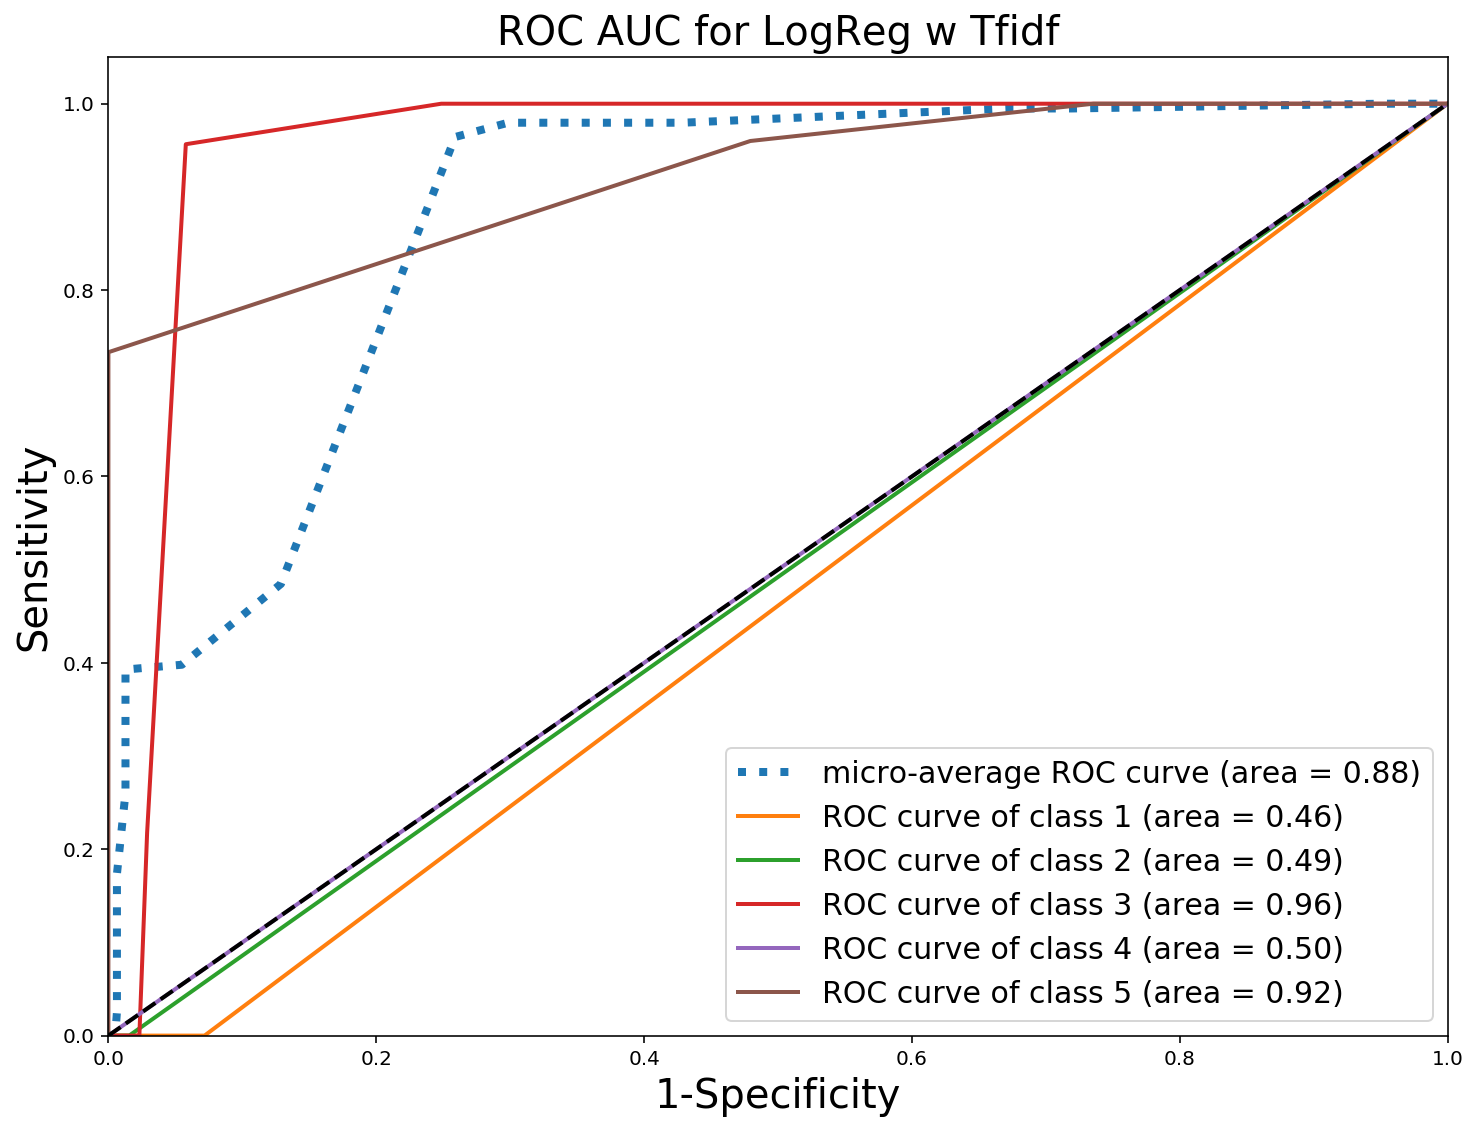

In [32]:
#making a copy of X_legit and y for computation and plotting of ROC AUC for the respective rating classes and micro-average
X_copy = X_legit.copy()

y_copy = y.copy()

# Binarize the output
y_copy = label_binarize(y_copy, classes=[1.0, 2.0, 3.0, 4.0, 5.0])
n_classes = y_copy.shape[1]

# shuffle and split training and test sets
X_copy_train, X_copy_test, y_copy_train, y_copy_test = train_test_split(X_copy, y_copy, test_size=0.2,
                                                    random_state=42, stratify=y_copy)

#instantiate scaler since not all of the features are of the same scale, eg. review_count and avg_store_rating
ss1 = StandardScaler()

#fitting the train and transforming both the train and test sets
X_copy_train_sc = ss1.fit_transform(X_copy_train)
X_copy_test_sc = ss1.transform(X_copy_test)

# Learn to predict each class against the other using the params of tuned model with random_state set to 42 so that the values and curves do not waver
classifier = OneVsRestClassifier(LogisticRegression(C=0.01519911082952933,class_weight='balanced',penalty='l1',solver='liblinear',random_state=42))
y_score = classifier.fit(X_copy_train_sc, y_copy_train).predict_proba(X_copy_test_sc)

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_copy_test[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_copy_test.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Plot all ROC curves and micro-averaged one
plt.figure(figsize=(12,9))
lw=2
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]), linestyle=':', linewidth=4)
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i+1, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('1-Specificity',fontsize=20)
plt.ylabel('Sensitivity',fontsize=20)
plt.title('ROC AUC for LogReg w Tfidf',fontsize=20)
plt.legend(loc="lower right",fontsize=15)
plt.show()

In [33]:
#calculating one-vs-one and one-vs-rest micro-averaged ROC AUC to check if there is a difference between both
y_prob = classifier.predict_proba(X_copy_test_sc)
micro_roc_auc_ovo = roc_auc_score(y_copy_test, y_prob, multi_class="ovo",
                                     average="micro")
micro_roc_auc_ovr = roc_auc_score(y_copy_test, y_prob, multi_class="ovr",
                                     average="micro")
print("One-vs-One ROC AUC score:\n{:.6f} "
      "(micro-averaged)"
      .format(micro_roc_auc_ovo))
print("One-vs-Rest ROC AUC score:\n{:.6f} "
      "(micro-averaged)"
      .format(micro_roc_auc_ovr))

One-vs-One ROC AUC score:
0.878329 (micro-averaged)
One-vs-Rest ROC AUC score:
0.878329 (micro-averaged)


In [34]:
#calculating one-vs-one and one-vs-rest ROC AUC weighted by prevalence to check if there is a difference between both
y_prob = classifier.predict_proba(X_copy_test_sc)
weighted_roc_auc_ovo = roc_auc_score(y_copy_test, y_prob, multi_class="ovo",
                                     average="weighted")
weighted_roc_auc_ovr = roc_auc_score(y_copy_test, y_prob, multi_class="ovr",
                                     average="weighted")
print("One-vs-One ROC AUC score:\n{:.6f} "
      "(weighted by prevalence)"
      .format(weighted_roc_auc_ovo))
print("One-vs-Rest ROC AUC score:\n{:.6f} "
      "(weighted by prevalence)"
      .format(weighted_roc_auc_ovr))

One-vs-One ROC AUC score:
0.714407 (weighted by prevalence)
One-vs-Rest ROC AUC score:
0.714407 (weighted by prevalence)


## Model Summary and Result Interpretation
---

<ul>

- Tuned LogReg is unable to predict ratings 1, 2, and 4 although it could predict ratings 3 and 5 pretty well based on multi-class ROC AUC plots and scores.
- Accuracy of 0.81, Micro-Averaged precision of 0.81, Micro-Averaged recall of 0.81, Micro-Averaged $F_1$ of 0.81
- Micro-Averaged ROC AUC of 0.88, weighted by prevalence ROC AUC of 0.71